# CreditCardApproval MachineLearning Diana Max

## Setup notebook & fetch data

In [1]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
#import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer, TargetEncoder, label_binarize
from sklearn.metrics import (
    auc, 
    accuracy_score, 
    confusion_matrix, 
    mean_squared_error, 
    make_scorer
)

from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV, 
    KFold, 
    RandomizedSearchCV, 
    train_test_split, 
    StratifiedKFold, 
    cross_validate,
    RepeatedStratifiedKFold
)

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.base import clone
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
from sklearn.metrics import (
    accuracy_score,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    auc,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)

In [3]:
credit_approval = fetch_ucirepo(id=27)

X = credit_approval.data.features
y = credit_approval.data.targets
df = credit_approval.data.original

## preprocessing

In [4]:
"""
Maybe add some more advanced techniques from here later: https://scikit-learn.org/stable/modules/preprocessing.html

"""

'\nMaybe add some more advanced techniques from here later: https://scikit-learn.org/stable/modules/preprocessing.html\n\n'

### feature engineering: mixed numerical categorical feature space (this is old code, use fully numerical feature space for now)

In [5]:
make_column_transformer(
    (
        make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(drop='first')
        ),
        ['A1']
        
    ),
    (
        make_pipeline(
            SimpleImputer(strategy='median'),
            MinMaxScaler()
        ),
        ['A2']
    ),
    (
        make_pipeline(
            FunctionTransformer(lambda col: col.mask(col != 'u', 'non-u')),
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(drop='first')
           ),
        ['A4']
    ),
    (
        make_pipeline(
            FunctionTransformer(lambda col: col.replace({'v':'v', 'h':'h','bb':'other','ff':'other','j':'other','z':'other','dd':'other','n':'other','o':'other'})),
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(drop='first')
        ),
        ['A7']
    ),
    (
        make_pipeline(
            FunctionTransformer(lambda col: col.replace({'g':'g', 's':'non-g','p':'non-g'})),
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(drop='first')
        ),
        ['A13']
    ),
    (
        'test',
        make_pipeline(
            FunctionTransformer(np.log1p),
            SimpleImputer(strategy='median'),
            MinMaxScaler()
        ),
        ['A11','A14','A15']
    ),
    # continuous default
    (
        make_pipeline(
            MinMaxScaler(),
        ),
        ['A3','A8']
    ),
    # categorical default
    (
        make_pipeline(
            OneHotEncoder(drop='first'),
        ),
        ['A9','A10', 'A12']
    ),
    
    # remove: A5, A6
    remainder='drop'
)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'))]),
                                 ['A1']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['A2']),
                                ('pipeline-3',
                                 Pipeline(steps=[('functiontransformer...
                                ('test', 'test',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<ufunc 'log1p'>)),
                                                 ('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())])),
                                ('pipeline-6',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['A3', 'A8']),
                                ('pipeline-7',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='first'))]),
                                 ['A9', 'A10', 'A12'])])

### feature engineering: fully numerical feature space

#### variant 1: include A7

In [6]:
column_tweaker_include_a7 = make_column_transformer(
    (
        make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(sparse_output=False, drop='first')
        ),
        ['A1','A9','A10','A12']
    ),
    (
        make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            FunctionTransformer(lambda col: label_binarize(col, classes=['u']))
        ),
        ['A4']
    ),
    (
        make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            FunctionTransformer(lambda col: label_binarize(col, classes=['g']))
        ),
        ['A5']
    ),
    (
        make_pipeline(
            TargetEncoder(),
            SimpleImputer(strategy='median')
        ),
        ['A6', 'A7']
    ),
    (
        make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            FunctionTransformer(lambda col: label_binarize(col, classes=['g']))
        ),
        ['A13']
    ),
    (
        make_pipeline(
            FunctionTransformer(np.log1p),
            SimpleImputer(strategy='median')
        ),
        ['A2','A3','A8','A11','A14','A15']
    ),

    # leave everything else untouched
    remainder='drop'
)

#### variant 2: exclude A7

In [7]:
column_tweaker_exclude_a7 = make_column_transformer(
    (
        make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(sparse_output=False, drop='first')
        ),
        ['A1','A9','A10','A12']
    ),
    (
        make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            FunctionTransformer(lambda col: label_binarize(col, classes=['u']))
        ),
        ['A4']
    ),
    (
        make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            FunctionTransformer(lambda col: label_binarize(col, classes=['g']))
        ),
        ['A5']
    ),
    (
        make_pipeline(
            TargetEncoder(),
            SimpleImputer(strategy='median')
        ),
        ['A6']
    ),
    (
        make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            FunctionTransformer(lambda col: label_binarize(col, classes=['g']))
        ),
        ['A13']
    ),
    (
        make_pipeline(
            FunctionTransformer(np.log1p),
            SimpleImputer(strategy='median')
        ),
        ['A2','A3','A8','A11','A14','A15']
    ),

    # leave everything else untouched
    remainder='drop'
)

### feature scaling

In [8]:
column_scaler = MinMaxScaler()

### PCA

In [9]:
column_pca = PCA(n_components=.99, svd_solver='full')

### put together pipelines

#### feature engineering pipeline 1

In [10]:
preprocessing_pipe = make_pipeline(
    column_tweaker_exclude_a7,
    column_scaler,
    column_pca
)
preprocessing_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['A1', 'A9', 'A10', 'A12']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('functiontr...
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001BAF97DC040>))]),
                                                  ['A13']),
                                                 ('pipeline-6',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['A2', 'A3', 'A8', 'A11',
                                                   'A14', 'A15'])])),
                ('minmaxscaler', MinMaxScaler()),
                ('pca', PCA(n_components=0.99, svd_solver='full'))])

#### feature engineering pipeline 2

In [11]:
"""

In which different formats do we need the data for different classifiers ?

"""

'\n\nIn which different formats do we need the data for different classifiers ?\n\n'

## train test validation split

In [12]:
X_preprocessed = preprocessing_pipe.fit_transform(X=X, y=y.values.ravel())

In [13]:
X_train, X_test_validate, y_train, y_test_validate = train_test_split(X_preprocessed, y.values.ravel(), test_size=0.1)
X_train.shape, y_train.shape

((621, 12), (621,))

In [14]:
X_test, X_validate, y_test, y_validate = train_test_split(X_test_validate, y_test_validate, test_size=.5)
(X_test.shape, y_test.shape), (X_validate.shape, y_validate.shape)

(((34, 12), (34,)), ((35, 12), (35,)))

## train & optimise different models

### LogisticRegression (Linear Model)

In [15]:
y_test.ravel()


array(['-', '+', '+', '-', '-', '+', '-', '-', '-', '-', '+', '-', '-',
       '+', '+', '-', '-', '+', '+', '-', '-', '-', '+', '+', '-', '-',
       '-', '+', '-', '-', '+', '+', '-', '-'], dtype=object)

In [60]:
res = cross_validate(
    estimator=LogisticRegression(),
    X = X_preprocessed,
    y =  y.values.ravel(),
    cv=StratifiedKFold(n_splits=7, shuffle=True, random_state=42),
    scoring="accuracy")

In [61]:
res['test_score'].mean()

0.8565686014665606

In [62]:
lr = LogisticRegression().fit(X_train, y_train)

In [64]:
accuracy_score(y_test, lr.predict(X_test))

0.9117647058823529

In [65]:
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           +       0.92      0.85      0.88        13
           -       0.91      0.95      0.93        21

    accuracy                           0.91        34
   macro avg       0.91      0.90      0.91        34
weighted avg       0.91      0.91      0.91        34



Text(0.5, 1.0, 'Precision-Recall curve')

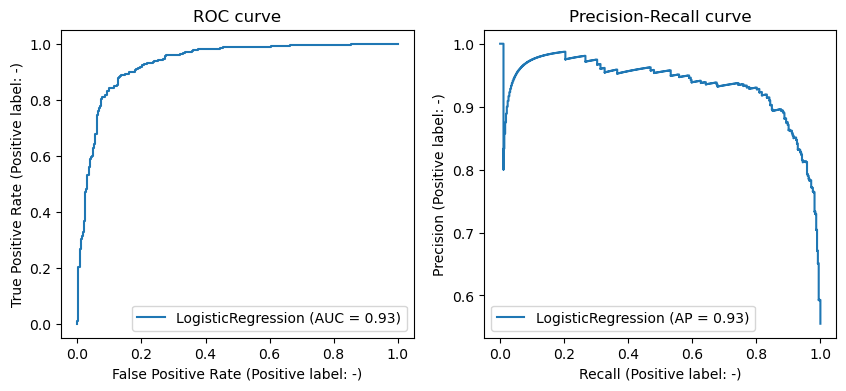

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
RocCurveDisplay.from_estimator(lr, X_preprocessed, y, ax=ax1)
ax1.set_title("ROC curve")
PrecisionRecallDisplay.from_estimator(lr, X_preprocessed, y, ax=ax2)
ax2.set_title("Precision-Recall curve")

#### GridSearchCV

In [72]:
import warnings

warnings.filterwarnings("ignore")

In [66]:
param_grid = [{'penalty': ['l2', None], 'C': [1., 2., 3.]}]

In [67]:
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

In [68]:
lg = LogisticRegression(random_state=42,solver='saga')

In [69]:
cv = StratifiedKFold(n_splits=10)

In [70]:
search = GridSearchCV(estimator=lr, scoring=scoring, param_grid=param_grid, cv=cv, refit='AUC')

In [73]:
search.fit(X_preprocessed, y.values.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=LogisticRegression(),
             param_grid=[{'C': [1.0, 2.0, 3.0], 'penalty': ['l2', None]}],
             refit='AUC',
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

In [74]:
search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_penalty', 'params', 'split0_test_AUC', 'split1_test_AUC', 'split2_test_AUC', 'split3_test_AUC', 'split4_test_AUC', 'split5_test_AUC', 'split6_test_AUC', 'split7_test_AUC', 'split8_test_AUC', 'split9_test_AUC', 'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC', 'split0_test_Accuracy', 'split1_test_Accuracy', 'split2_test_Accuracy', 'split3_test_Accuracy', 'split4_test_Accuracy', 'split5_test_Accuracy', 'split6_test_Accuracy', 'split7_test_Accuracy', 'split8_test_Accuracy', 'split9_test_Accuracy', 'mean_test_Accuracy', 'std_test_Accuracy', 'rank_test_Accuracy'])

In [75]:
search.cv_results_

{'mean_fit_time': array([0.01529398, 0.00610056, 0.00637367, 0.0062983 , 0.00509186,
        0.00549929]),
 'std_fit_time': array([0.0196543 , 0.00187574, 0.00179229, 0.00148679, 0.00093546,
        0.00128433]),
 'mean_score_time': array([0.00370016, 0.00320342, 0.00330324, 0.00300086, 0.00260193,
        0.00270011]),
 'std_score_time': array([0.00078099, 0.0013252 , 0.00101956, 0.00161378, 0.00066502,
        0.00063993]),
 'param_C': masked_array(data=[1.0, 1.0, 2.0, 2.0, 3.0, 3.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l2', None, 'l2', None, 'l2', None],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1.0, 'penalty': 'l2'},
  {'C': 1.0, 'penalty': None},
  {'C': 2.0, 'penalty': 'l2'},
  {'C': 2.0, 'penalty': None},
  {'C': 3.0, 'penalty': 'l2'},
  {'C': 3.0, 'penalty': None}],
 'split

In [76]:
search.best_params_ 

{'C': 1.0, 'penalty': 'l2'}

In [77]:
lr_best = LogisticRegression(penalty=search.best_params_['penalty'], C=search.best_params_['C'])

In [80]:
## mit den besten Parametern fitten
lr_best.fit(X_train, y_train)
accuracy_score(y_test, lr_best.predict(X_test))

0.9117647058823529

In [34]:
results = search.cv_results_

### Random Forest

In [53]:
clf = RandomForestClassifier(max_depth=6, random_state=0)

clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, random_state=0)

In [57]:
clf.score(X_validate, y_validate)

0.8

#### GridSearchCV

In [120]:
param_grid = [{'n_estimators': [50, 100, 200], 'min_samples_split': [3, 5]}]

In [121]:
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

In [122]:
rf = RandomForestClassifier(random_state=42)

In [123]:
cv = StratifiedKFold(n_splits=10)

In [124]:
search = GridSearchCV(estimator=rf, scoring=scoring, param_grid=param_grid, cv=cv, refit='AUC')

In [130]:
search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'min_samples_split': [3, 5],
                          'n_estimators': [50, 100, 200]}],
             refit='AUC',
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

In [131]:
search.cv_results_

{'mean_fit_time': array([0.19791608, 0.37230561, 0.71406629, 0.1765759 , 0.35552347,
        0.71946497]),
 'std_fit_time': array([0.01900905, 0.0322541 , 0.0072792 , 0.00189743, 0.00457618,
        0.00837831]),
 'mean_score_time': array([0.01118999, 0.01739161, 0.03089707, 0.00963178, 0.01669545,
        0.03090429]),
 'std_score_time': array([0.00133112, 0.00236689, 0.0010455 , 0.00078407, 0.00046056,
        0.00082802]),
 'param_min_samples_split': masked_array(data=[3, 3, 3, 5, 5, 5],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 200, 50, 100, 200],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'min_samples_split': 3, 'n_estimators': 50},
  {'min_samples_split': 3, 'n_estimators': 100},
  {'min_samples_split': 3, 'n_estimators': 200},
  {'min_samples_split': 5, 'n_estimators': 50},

In [132]:
search.best_params_ 

{'min_samples_split': 3, 'n_estimators': 50}

In [133]:
rf_best = RandomForestClassifier(n_estimators=search.best_params_['n_estimators'], min_samples_split=search.best_params_['min_samples_split'])

In [134]:
## mit den besten Parametern fitten
rf_best.fit(X_train, y_train)
accuracy_score(y_test, rf_best.predict(X_test))

0.9411764705882353

### SupportVectorClassifier

### Adaboost

### Ensemble method

In [35]:
"""
Check if all these methods always categorize the same, or different samples wrong. If the later is the case, this would motivate using a ensemble method to balance strengths and weaknesses of different classifiers.

Maybe building some ensemble method that combines a (gradient boosted) dewcicion tree for the categorical variables with something like SVM for the continuous data.

This would obviate the need for target encoding of A6 and A7 and poosible better handle the many binary variables in the dataset. 
""";

## (Sequential Feature Selection)

In [36]:
"""
Further reduce dimensionality by SFS. This may give different results for different classifiers.
"""

'\nFurther reduce dimensionality by SFS. This may give different results for different classifiers.\n'

## model comparison